In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [ ]:
raw_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel/data/2019-2nd-ml-month-with-kakr/train.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel/data/2019-2nd-ml-month-with-kakr/test.csv')

# 데이터 전처리

In [ ]:
# 데이터 형태 확인
display(raw_train.info())
display(raw_train.head(3))
print(raw_train.shape, raw_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

None

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.0,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


(15035, 21) (6468, 20)


In [ ]:
# 결측치 및 중복 데이터 확인
n_nulls = raw_train.isnull().any(axis=1).sum()
n_duplicates = raw_train.duplicated().sum()
n_id_duplicates = raw_train.duplicated(subset=["id"]).sum()
print(f"결측치 수: {n_nulls}")
print(f"중복 행 수: {n_duplicates}")
print(f"중복된 ID: {n_id_duplicates}")

결측치 수: 0
중복 행 수: 0
중복된 ID: 0


In [ ]:
# 날짜 속성을 YYMM으로 변경(int)
raw_train['date'] = raw_train['date'].apply(lambda i: str(i)[:6]).astype(int)

# 히트맵으로 상관계수 파악
+ sqft_living, sqft_above, grade가 price와 상관계수가 높은 것을 확인

<Axes: >

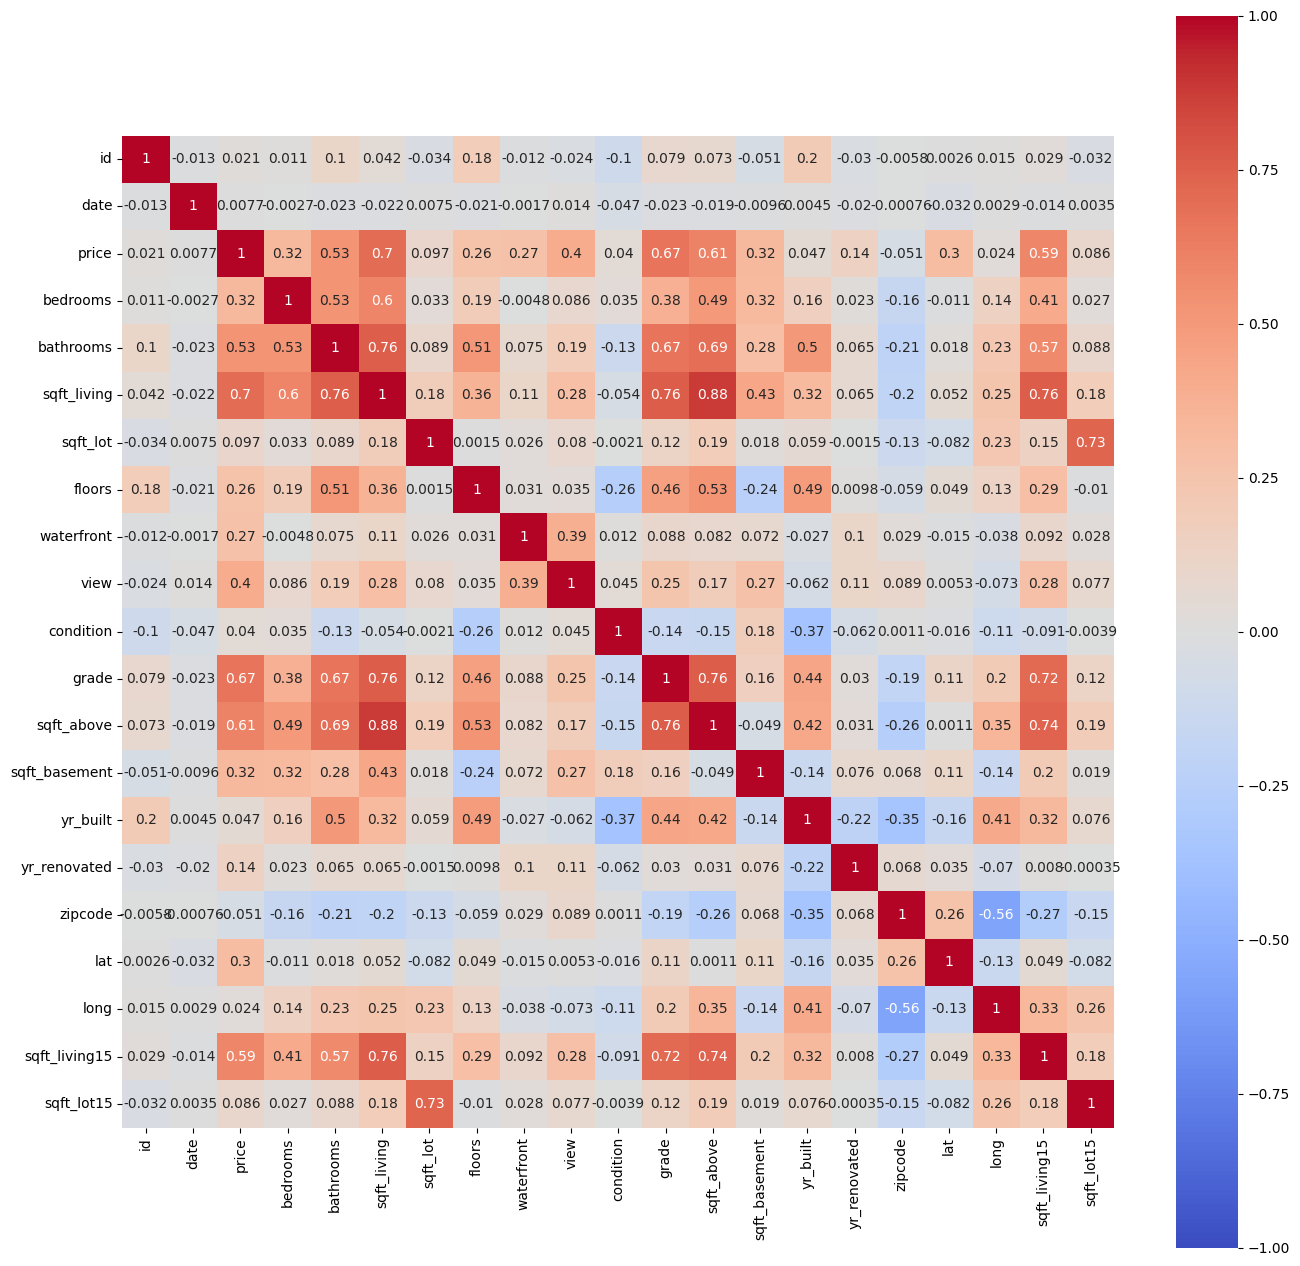

In [ ]:
# 상관계수 행렬 계산
corr_matrix = raw_train.corr()

# 히트맵 그리기
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True)

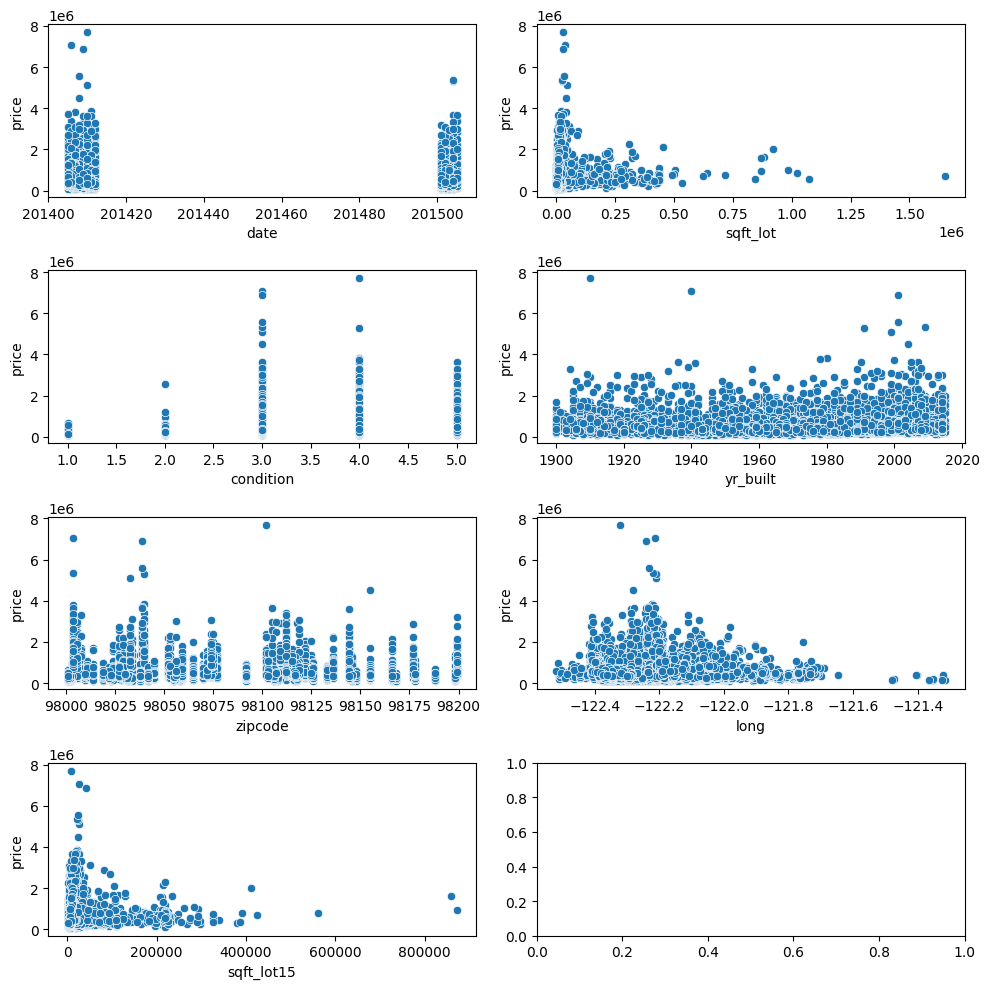

In [ ]:
# 위에서 price와 상관계수가 작은 값들을 시각화
# 몇몇 값들을 빼보려는 시도를 했으나 빼지 않았을 때 성능이 가장 좋았음
low_corr_columns = ['date', 'sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15']
fig, ax = plt.subplots(4, 2, figsize=(10,10))

for row in range(4):
  for col in range(2):
    if row*2 + col < 7:
      sns.scatterplot(data=raw_train, x=low_corr_columns[row*2 + col], y='price', ax=ax[row, col])

plt.tight_layout()

In [ ]:
# sqft_living = sqft_above + sqft_basement이기 때문에 sqft_living만 살리고 삭제
train = raw_train.drop(["sqft_above", "sqft_basement"], axis=1)
# 화장실 수와 방 수를 합친 total_rooms 속성을 만듬
train['total_rooms'] = train["bedrooms"] + train ["bathrooms"]
train = train.drop(["bedrooms", "bathrooms"], axis=1)
# 재개발 여부 속성 추가
train["is_renovated"] = (train["yr_renovated"] > 0).astype(int)

In [ ]:
train.columns

Index(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'total_rooms',
       'is_renovated'],
      dtype='object')

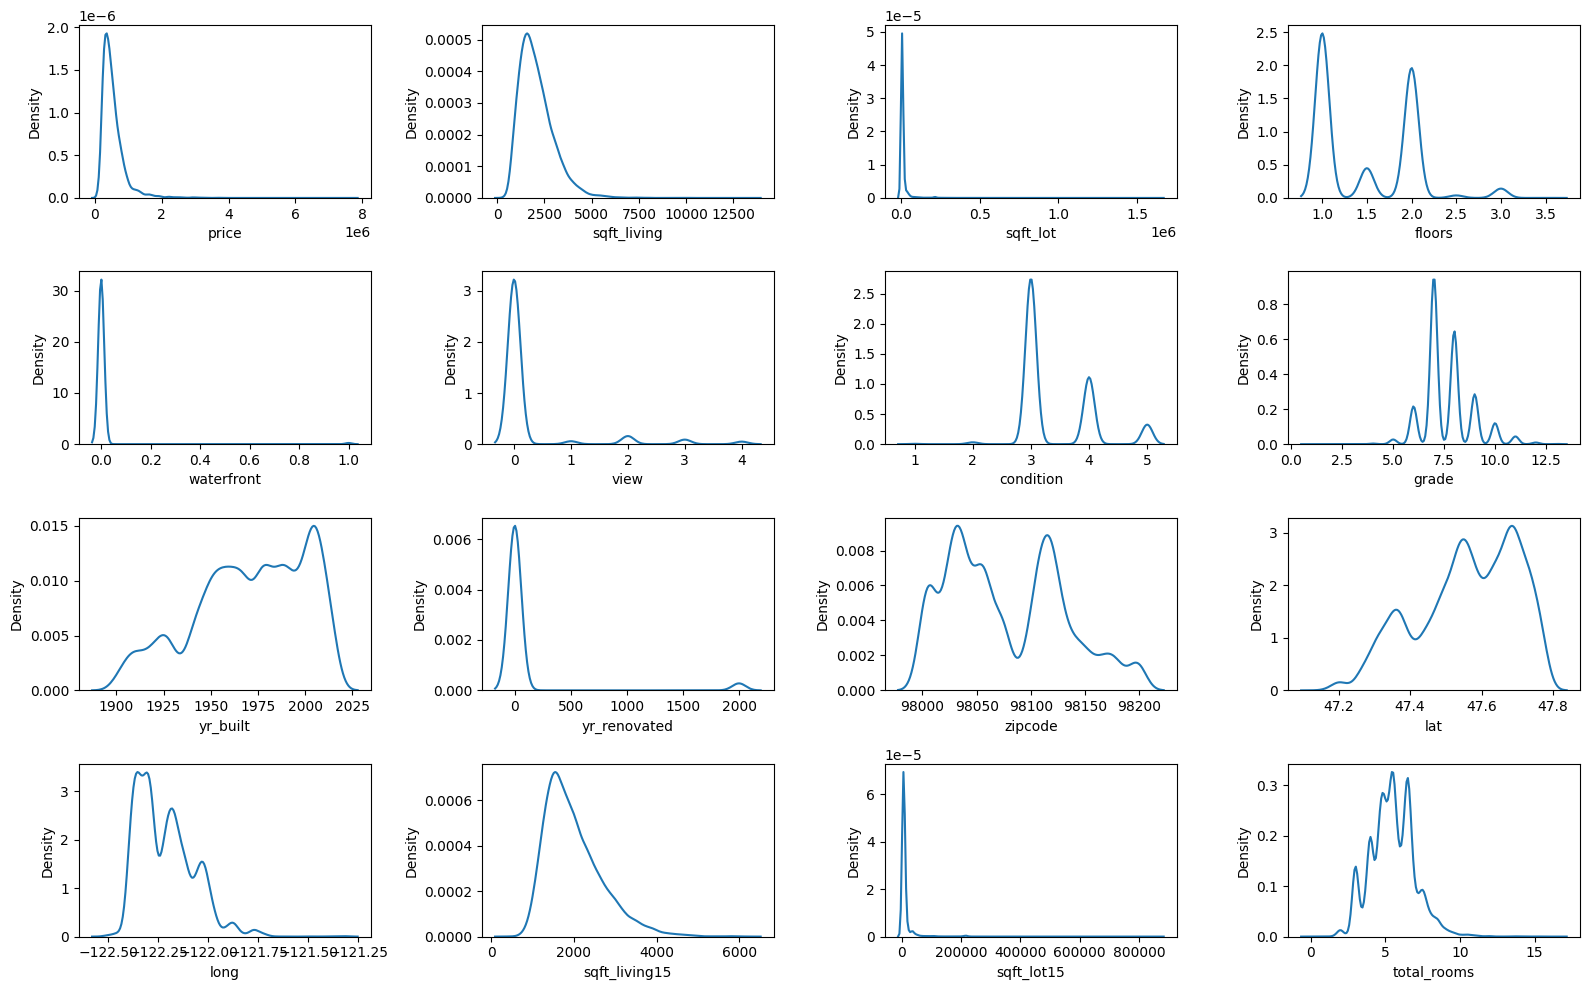

In [ ]:
# 데이터 분포 시각화
fig, ax = plt.subplots(4, 4, figsize=(16,10))

for row in range(4):
  for col in range(4):
    sns.kdeplot(data=train, x=train.columns[row*4 + col + 2], ax=ax[row, col])

plt.tight_layout()

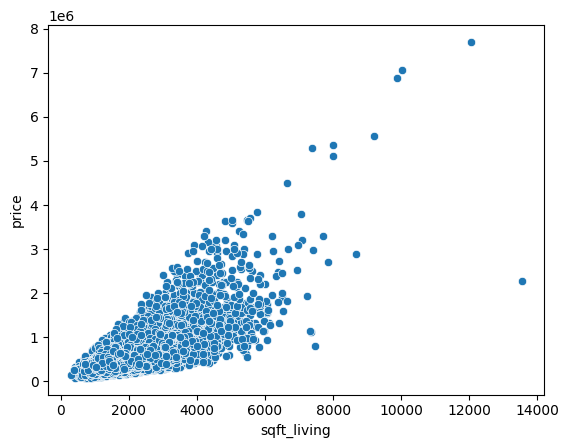

In [ ]:
# price와 상관계수가 가장 높은 특성이었던 sqft_living에 대한 산점도 확인
sns.scatterplot(data=train, x='sqft_living', y='price')
plt.show()

In [ ]:
# 값이 가장 큰 데이터가 이상치 같아 제거(가격이 너무 낮음)
print(train['sqft_living'].idxmax())

8912


In [ ]:
# 8912행을 삭제
train.drop(8912, inplace=True)

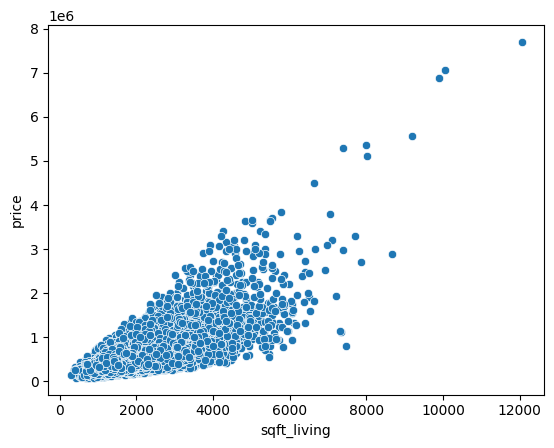

In [ ]:
sns.scatterplot(data=train, x='sqft_living', y='price')
plt.show()

In [ ]:
# 비대칭 그래프에 대해 로그 변환 실행
# feature에 대한 로그 변환은 효과가 미비한데 타겟(price)에 대한 로그 변환은 효과가 좋았음
skewed_columns = ['price', 'sqft_living', 'sqft_lot', 'sqft_lot15', 'sqft_living15']

for c in skewed_columns:
    train[c] = np.log1p(train[c])

# 모델링
+ 속도가 빠른 LGBMRegressor를 사용
+ RandomizedSearchCV를 사용하여 랜덤하게 하이퍼파라미터를 탐색

In [ ]:
# 타겟데이터 분리
y = train["price"]
# id, 타겟데이터 삭제
train.drop(['id', 'price'], axis=1, inplace=True)

In [ ]:
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
random_state=2025
lightgbm = lgb.LGBMRegressor(random_state=random_state, verbose=-1)

param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 15),
    'num_leaves': randint(20, 150),
    'min_child_samples': randint(10, 100),
    'min_child_weight': uniform(0.001, 0.1),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1.0),
    'reg_lambda': uniform(0, 1.0)
}

def RandomSearchCVModel(model, train, y, param_dist, verbose=2, n_jobs=-1):
    model = RandomizedSearchCV(estimator = model,
                          param_distributions = param_dist,
                          cv = 5, # 5-fold 교차검증
                          scoring = 'neg_mean_squared_error', # 평가기준인 rmse를 사용
                          n_jobs = -1, # 모든 cpu 사용
                          random_state = random_state)

    # rmse 점수를 측정하기 위한 테스트 세트 분리
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

    # 모델 fit
    model.fit(X_train, y_train)

    # 테스트 셋에 대한 RMSE 출력
    best_model = model.best_estimator_
    y_pred = best_model.predict(X_test)
    print(rmse(y_test, y_pred))

    # 최적의 파라미터 출력
    best_params = model.best_params_
    results = pd.Series(best_params)
    display(best_params)

    return best_model, best_params

model, best_params = RandomSearchCVModel(lightgbm, train, y, param_dist)

103706.06607593628


{'colsample_bytree': np.float64(0.78076503918989),
 'learning_rate': np.float64(0.03941674294267201),
 'max_depth': 7,
 'min_child_samples': 27,
 'min_child_weight': np.float64(0.10008984387457873),
 'n_estimators': 674,
 'num_leaves': 60,
 'reg_alpha': np.float64(0.28415373715629744),
 'reg_lambda': np.float64(0.46889926792649606),
 'subsample': np.float64(0.904709276182747)}

# 제출

In [ ]:
# test 데이터 전처리
test_id = raw_test['id']
test = raw_test.drop(["id", "sqft_above", "sqft_basement"], axis=1)
test['date'] = test['date'].apply(lambda i: str(i)[:6]).astype(int)
test['total_rooms'] = test["bedrooms"] + test ["bathrooms"]
test = test.drop(["bedrooms", "bathrooms"], axis=1)
test["is_renovated"] = (test["yr_renovated"] > 0).astype(int)

# log 변환
for c in ['sqft_living', 'sqft_lot', 'sqft_lot15', 'sqft_living15']:
    test[c] = np.log1p(test[c])

In [ ]:
# 전체 데이터로 다시 한 번 모델학습
# 이걸 해주는 경우가 성능이 더 좋았음
final_model = lgb.LGBMRegressor(**best_params, verbose=-1, random_state=random_state)
final_model.fit(train, y)

LGBMRegressor(colsample_bytree=np.float64(0.78076503918989),
              learning_rate=np.float64(0.03941674294267201), max_depth=7,
              min_child_samples=27,
              min_child_weight=np.float64(0.10008984387457873),
              n_estimators=674, num_leaves=60, random_state=2025,
              reg_alpha=np.float64(0.28415373715629744),
              reg_lambda=np.float64(0.46889926792649606),
              subsample=np.float64(0.904709276182747), verbose=-1)

In [ ]:
# 타겟에 대해 로그 변환을 했으니 마지막엔 다시 원래 값으로 돌려줌
y_pred = np.expm1(final_model.predict(test))

In [ ]:
sub = pd.DataFrame(data={'id':test_id,'price':y_pred})
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel/submission/submission_final.csv', index=False)